## Exercise 05 – EO image data processing and retrieval

In [8]:
#libraries needed
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LinearRegression
#import seaborn as sb
from matplotlib.pyplot import imshow
import pprint as pp
from collections import defaultdict
from sklearn.metrics import confusion_matrix,cohen_kappa_score,precision_score
from sklearn.preprocessing import StandardScaler



### 1. Plot the acquired spectral reflectance vs and spectral radiance and possibly superimpose the class label to each observation, explaining why you expect these classes can represent particle cloud and sea surface radiative signature.

As we can see in the plot, we expect these classes representing parcicle cloud and sea surface radiative signature since the ones with higher values of the spectral reflectance are the ones associated to the class of cloud particles.
This is because clouds are much brighter than clear scene and reflectance component from the cloud is more variable compared to reflectance component from clear pixels, as we could get from the sea surface

In [9]:
doc_files = ["Image_ch1_spectralRadiance.dat",
             "Image_ch2_spectralReflectance.dat",
             "Image_class_insituLabels.dat",
             "Image_parameter_insituMeasurements.dat"]

doc_names = ["Spectral_Radiance",
             "Spectral_Reflectance",
             "class",
             "Temperature [K]"]

def import_files(files,file_names):
    results = dict() # dict where to store all the files
    for e,files in enumerate(files):
        result = list()
        file = open(files, 'r', ) # open the file
        lines = file.readlines()
        for x in lines:
            result.append([float(measure.strip()) for measure in x.split('\t')[:-1]])

        results[file_names[e]] = [v for r in result for v in r] #unpack the list of lists
            
        if file_names[e] == 'class':
            results['Class_label'] = ['sea surface' if int(value)==2 
              else'cloud particles'
                 for value in results['class']] # add class label
    file.close()
    return results

dictionary = import_files(doc_files,doc_names)
df_images = pd.DataFrame.from_dict(dictionary)
df_images.head()

,Spectral_Radiance,Spectral_Reflectance,class,Class_label,Temperature [K]
0,2.068526,0.579204,1.0,cloud particles,277.39425
1,1.588779,0.725697,1.0,cloud particles,266.11364
2,2.308740,0.838262,1.0,cloud particles,277.84215
3,4.651697,0.338762,2.0,sea surface,297.25935
4,3.197330,0.246227,2.0,sea surface,282.75330


NameError: name 'ax' is not defined

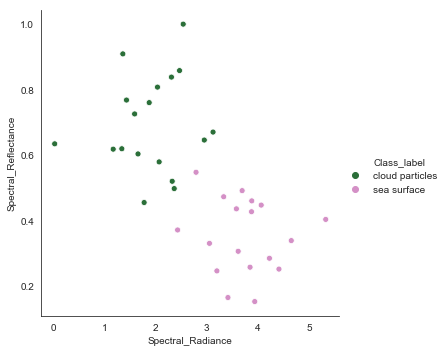

In [10]:
sns.set_style("white")
sns.relplot(data=df_images,x="Spectral_Radiance", y="Spectral_Reflectance", hue='Class_label',
             alpha=1, palette='cubehelix')
ax.xaxis.label.set_color('k')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title('Reflectance VS Radiance', color='black', fontsize=30, pad=10)

### 2. Perform a Lloyd’s k-means unsupervised classification and, by using the in-situ class labels, compute the confusion (or contingency) matrix (CM).

In [11]:
#create a new dataframe with the first two columns used for the cluster feature
X=df_images.iloc[:, lambda df_images: [0, 1]]
print(type(X))
X.head()

<class 'pandas.core.frame.DataFrame'>


,Spectral_Radiance,Spectral_Reflectance
0,2.068526,0.579204
1,1.588779,0.725697
2,2.308740,0.838262
3,4.651697,0.338762
4,3.197330,0.246227


In [12]:
#performing the Lloyd's k-means unsupervised classicifaction
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
y_kmeans

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0])

C:\Users\Giumas\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


[Text(92.68,0.5,'Predicted')]

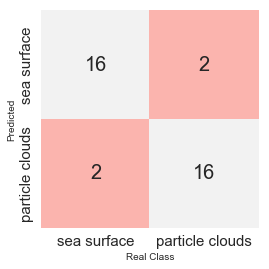

In [13]:
#colonna dataframe iniziale, parte vera, poi una nuova classe dell'algoritmo e plottare . devono essere stessa cosa , stessi valori
#computing the confusion matrix
#Defining a new dataframe with a new column
df_new = pd.DataFrame.from_dict(dictionary)
df_new.head()
# create def for category to number 0/1
def tran_cat_to_num(df):
    if df['Class_label'] == 'cloud particles':
        return 0
    else:
        return 1
##
df_new['y_true']=df_new.apply(tran_cat_to_num,axis=1)
#df_new
#y=df_new.iloc[:, lambda df_new: [5]]
y=df_new.iloc[:,[5]].as_matrix()
y
#y= df_new[["y_true"]].to_numpy()
y_true=y
y_pred=y_kmeans

cm=confusion_matrix(y_true, y_pred)

imshow(np.asarray(cm))



ax = sns.heatmap(cm, cmap= 'Pastel1', annot=True,annot_kws={"size": 20},cbar=False)
ax.set_xticklabels(['sea surface','particle clouds'],size=15)
ax.set_yticklabels(['sea surface','particle clouds'],va='center',size=15)

ax.set(xlabel='Real Class')
ax.set(ylabel='Predicted')

### 3. From the confusion matrix, compute the probability of detection (POD, sensitivity or true positive), false alarm rate (FAR, false negative) and Cohen’s index . POD= …, FAR=…Coehn=…


In [14]:
#defining the FALSE NEGATIVE AND TRUE POSITIVE

FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# False negative rate
FNR = FN/(TP+FN)

#cohen index

cohen_kappa_score(y_true, y_pred)

print(
    "Cohen kappa score: " +str(cohen_kappa_score(y_true, y_pred)),
    "POD (or sensitivity): " + str(TPR.flat[0]),
    "FAR (or False negative rate): " + str(FNR.flat[0]),
    sep='\n'
)   

Cohen kappa score: 0.7777777777777778
POD (or sensitivity): 0.8888888888888888
FAR (or False negative rate): 0.1111111111111111


### 4. Determine how much variance is explained by the first principal component of the acquired channels?

In [17]:
covar_matrix  = PCA(n_components=2) 
scaled = StandardScaler().fit_transform(df_images.iloc[:,:2]) 
pca_transformation = covar_matrix.fit_transform(scaled)

print("Explained variance of PC1: "+str(round(covar_matrix.explained_variance_ratio_[0],2)),
      "Explained variance of PC2: "+str(round(covar_matrix.explained_variance_ratio_[1],2)),
      sep='\n'
     )

Explained variance of PC1: 0.82
Explained variance of PC2: 0.18


### 5. By using the first principal component, re-perform a Lloyd’s k-means unsupervised classification and then compute the confusion matrix (CM) and Cohen’s index .


In [18]:
df_pca = pd.DataFrame(pca_transformation, columns=['PC1','PC2'])
df_pca['Class_label']=df_images['Class_label']

In [19]:
df_pca.head()

,PC1,PC2,Class_label
0,0.647820,-0.288520,cloud particles
1,1.430294,-0.099794,cloud particles
2,1.357908,0.718862,cloud particles
3,-1.747703,0.512950,sea surface
4,-1.154464,-0.693770,sea surface


In [20]:
X_p=df_pca.iloc[:, lambda df_pca: [0, 1]]

In [21]:
X_p.head()

,PC1,PC2
0,0.647820,-0.288520
1,1.430294,-0.099794
2,1.357908,0.718862
3,-1.747703,0.512950
4,-1.154464,-0.693770


In [22]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_p)
y_kmeansp = kmeans.predict(X_p)
y_kmeansp

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [23]:
df_pcanew = pd.DataFrame(pca_transformation, columns=['PC1','PC2'])
df_pcanew['Class_label']=df_images['Class_label']
df_pcanew.head()

,PC1,PC2,Class_label
0,0.647820,-0.288520,cloud particles
1,1.430294,-0.099794,cloud particles
2,1.357908,0.718862,cloud particles
3,-1.747703,0.512950,sea surface
4,-1.154464,-0.693770,sea surface


In [24]:
df_pcanew['y_pcatrue']=df_pcanew.apply(tran_cat_to_num,axis=1)
df_pcanew.head()

,PC1,PC2,Class_label,y_pcatrue
0,0.647820,-0.288520,cloud particles,0
1,1.430294,-0.099794,cloud particles,0
2,1.357908,0.718862,cloud particles,0
3,-1.747703,0.512950,sea surface,1
4,-1.154464,-0.693770,sea surface,1


In [25]:
y_pca=df_pcanew.iloc[:,[3]].as_matrix()

C:\Users\Giumas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [26]:
y_pca

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1]], dtype=int64)

[Text(92.68,0.5,'Predicted')]

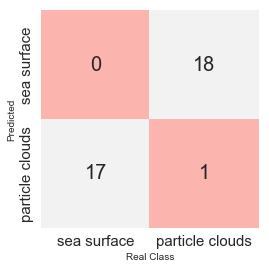

In [27]:
#y= df_new[["y_true"]].to_numpy()
y_true=y_pca
y_pred=y_kmeansp

cm=confusion_matrix(y_true, y_pred)


imshow(np.asarray(cm))

cm

ax = sns.heatmap(cm, cmap= 'Pastel1', annot=True,annot_kws={"size": 20},cbar=False)
ax.set_xticklabels(['sea surface','particle clouds'],size=15)
ax.set_yticklabels(['sea surface','particle clouds'],va='center',size=15)

ax.set(xlabel='Real Class')
ax.set(ylabel='Predicted')

In [28]:
print(
    "Cohen kappa score: " +str(cohen_kappa_score(y_true, y_pred))
)

Cohen kappa score: -0.9444444444444444
